# 手撕Transformer
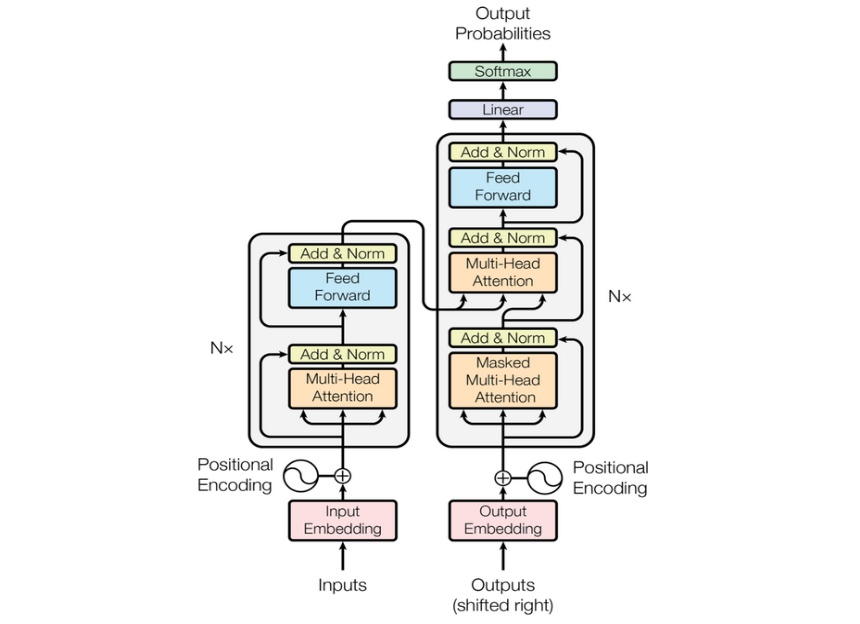

## 一、位置编码
位置编码(Positional Encoding)是[Transformer](https://gitcode.com/gh_mirrors/tr/transformer/overview?utm_source=highlight_word_gitcode&word=transformer&isLogin=1)模型中的一个重要组成部分，用于在序列数据中引入位置信息。由于Transformer模型本身不具备处理序列顺序的能力（因为它完全基于自注意力机制，没有递归或卷积结构），位置编码的引入是的模型能够利用序列的顺序信息。

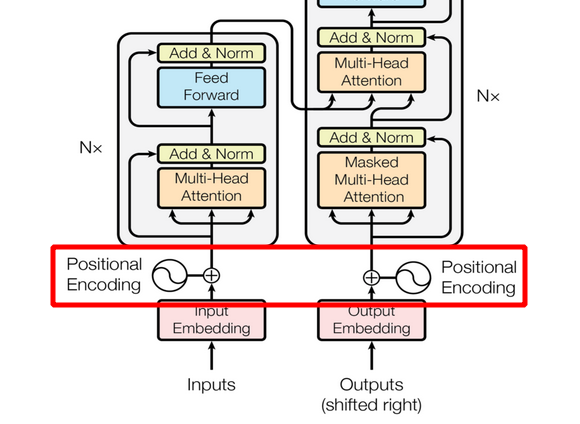

**位置编码的原理**
位置编码通过输入嵌入向量中添加一个与位置相关的向量来实现。具体来说，对于每一个位置($pos$)和每个维度($i$)，位置编码向量($PE\left(pos,2i\right)$)和($PE\left(pos,2i+1\right)$)分别由以下公式计算


$$
\begin{aligned}
PE\left(pos,2i\right)&=sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)\\
PE\left(pos,2i+1\right)&=cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{aligned}
$$
其中$d_{model}$是模型的维度，$pos$是位置，$i$是维度索引

**代码解释**
以下是`PositionalEncoder`

In [61]:
import torch
import torch.nn as nn
import math
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=80):
        super().__init__()
        self.d_model = d_model
        # 创建一个常量PE矩阵
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(2*torch.arange(0, d_model, 2)*-(math.log(10000.0))/d_model)
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
          
    def forward(self, x):
        # 使得单词嵌入表示相对大一些
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len]
        return x

可视化验证

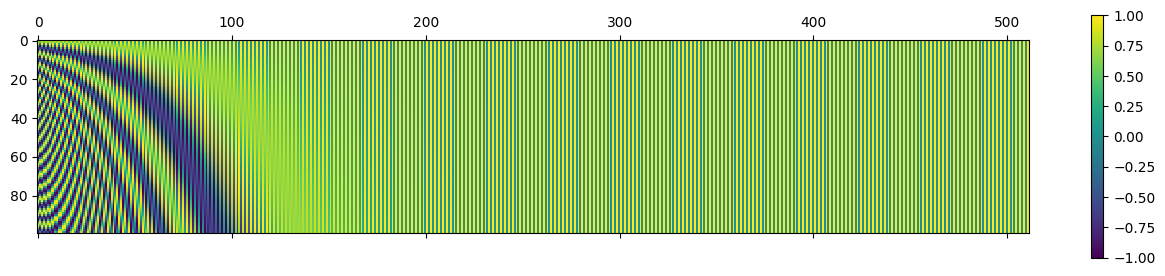

In [62]:
y = PositionalEncoder(512, 100)
import numpy as np
import matplotlib.pyplot as plt
z = y.pe.squeeze(0)
cax = plt.matshow(z)
plt.gcf().colorbar(cax)

**1. 初始化**
- `d_model`：模型的维度
- `max_seq_len`：序列的最大长度
- `pe`：一个大小为`(max_seq_len, d_model)`的零矩阵，用于存储位置编码
 
**2. 计算位置编码**
- 对于每一个位置`pos`和每一个维度`i`，计算`sin`和`cos`值，并将其存储在`pe`矩阵中
- `pe`矩阵通过`unsqueeze(0)`增加一个批次维度，使其形状为`(1, max_seq_len, d_model)`
 
**3. 注册缓冲区**
- `self.register_buffer(‘pe’)`：将`pe`注册为一个缓冲区，这样它将会在模型保存和加载时被保存，但不会被优化器更新

**4. 前向传播**
- `x = x * math.sqrt(self.d_model)`：将输入全如向量`x`放大，以确保嵌入向量的值不会被位置编码淹没
- `x = x + self.pe[:, :seq_len]`：将位置编码添加到向量中，其中`seq_len`是输入序列的实际长度

## 二、多头注意力
多头注意力机制（Multi-Head Attention）是[Transformer模型](https://so.csdn.net/so/search?q=Transformer%E6%A8%A1%E5%9E%8B&spm=1001.2101.3001.7020)中的一个关键组件，用于处理序列数据，特别是在自然语言处理任务中。它的主要思想是将输入的查询（Query）、键（Key）和值（Value）通过多个独立的注意力头（Attention Heads）进行处理，然后将这些头的输出拼接起来并通过一个线性层进行整合。这种机制可以捕捉序列中不同位置的多种复杂关系。

以下是对多头注意力机制的详细解释：

**1. 初始化**
- `d_model`: 输入和输出的维度
- `heads`: 注意力头的数量
- `d_k`: 注意力头的维度，计算方式`d_model//heads`
- 线性层：用于将输入的`query`、`key`和`value`分别映射到`d_model`维度
- 丢弃层(Dropout): 用于防止过拟合
- 输出线性层：用于将拼接后的多头注意力输出映射回`d_model`维度

**2. 注意力计算**
- `attention`方法计算注意力分数。首先，通过矩阵策划嗯法计算`query`和`key`的点积，然后除以$\sqrt{d\_k}$进行缩放，以防止梯度消失或爆炸
- 如果提供了掩码(mask)，则将掩码中为0的位置对应的分数设置为一个非常小的值（如`-1e9`），以确保这些位置在`softmax`后为0
- 对分数进行`softmax`操作，使其成为一个概率分布
- 应用丢弃层(Dropout)

**3. 前向传播**
- 对输入的`query`、`key`和`value`分别进行线性变换，然后重塑为多头形式
- 将这些张量进行置换，以便在注意力计算中正确对齐
- 调用`attention`方法计算多头注意力
- 将多头注意力的输出进行转置和拼接，然后通过输出线性层进行整合

以下是完整的代码实现：

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.q_linear = nn.linear(d_model, d_model)
        self.v_linear = nn.linear(d_model, d_model)
        self.k_linear = nn.linear(d_model, d_model)
        self.dropoutt = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def attention(self, q, k, v, d_k, mask=None, dropout=None):
        scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
        if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask==0, -1e9)
        scores = F.softmask(scores)
        if dropout is not None:
            scores = dropout(scores)
        output = torch.matmul(scores, v)
        return output

    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k).transpose(1,2)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k).transpose(1,2)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k).transpose(1,2)
        scores = self.attention(q, k, v, self.d_k, maks, self.dropout)
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)
        return output
        

转置操作`transpose(1,2)`是为了在多头注意力计算中正确对齐每个头的`query`、`key`和`value`，指的是，矩阵计算在`sequence_length`,`d_k`这两个维度上进行

## 三、前馈神经网络(FeedForward)和层归一化(NormLayer)

**FeedForward模块**

FeedForward模块是一个简单的前馈神经网络，通常紧跟在多头注意力机制之后。它由两个线性层和一个激活函数组成，中间包含一个丢弃层(Dropout)以防止过拟合。

**代码解析**

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

- **初始化**
    - `d_model`: 输入和输出的维度
    - `d_ff`: 中间层的维度，默认值设置为2048
    - `dropout`：丢弃层，默认值设为0.1
    - `self.linear1`：第一个线性层，将输入从`d_model`维度映射到`d_ff`维度
    - `self.dropout`：丢弃层，用于防止过拟合
    - `self.linear2`：第二个线性层，将输入从`d_ff`维度映射回`d_model`维度
- **前向传播**
    - `self.linear1(x)`: 将输入`x`从`d_model`维度映射到`d_ff`维度
    - `F.relu(self.linear1(x))`: 应用`ReLU`激活函数
    - `self.dropout(F.relu(self.linear1(x)))`: 应用丢弃层
    - `self.linear2(x)`: 将输入从`d_ff`维度映射会`d_model`维度

**NormLayer模块**